In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import KFold

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML
from datetime import datetime
from langdetect import detect
import re
import copy

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

In [8]:
MODEL_NAME = "https://tfhub.dev/google/nnlm-en-dim50/2"

## GET DATA

In [9]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [10]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [11]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '285192',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/oaD1ZQ3yGj6lacLdtqgdnQ__thumb/img/1mCz7HPEFMeqaqJHsDZwEUc9ftw=/fit-in/200x150/filters:strip_icc()/pic5558118.png',
  'name': 'Destinies',
  'yearpublished': '2021'},
 {'id': '223040',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/A7IOpPt-lHrMYsbRmxXWdQ__thumb/img/XoD3fXgApfY7-dfYyFeE6FVkbfY=/fit-in/200x150/filters:strip_icc()/pic6177962.jpg',
  'name': 'Fantasy Realms',
  'yearpublished': '2017'}]

In [12]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 26)
page number = 20 (max: 100, len: 17)
page number = 30 (max: 100, len: 12)
page number = 40 (max: 100, len: 9)
page number = 50 (max: 100, len: 4)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 3)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (97260, 4)


,id,username,rating,value
0,285192,Alarka,8.5,Players: 1-3 (1-2) Time: 90-150 Min Category: ...
1,285192,almi,N/A,2021-05
2,285192,androgeus,N/A,soll Ende Mai 21 lieferbar sein
3,285192,AnneWit,9,"On first play, this is another outstanding gam..."
4,285192,ArmyLee,N/A,KS Ed. - Sea of Sand - Myth & Folklore crossover
...,...,...,...,...
97255,167791,z_zadar,9,Some games are so much fun. Others can be a li...
97256,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
97257,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
97258,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [13]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [14]:
comments_df["value"] = comments_df["value"].astype(str)

In [15]:
# REMOVE URLs FROM COMMENTS

In [16]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [17]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [18]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 16430 for 'remove_short_comments' - min len: 25 - method: unrated


In [19]:
# REMOVE NON ENGLISH COMMENTS

In [20]:
# !conda install -c conda-forge langdetect

In [21]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [22]:
# comments_df = add_comments_lang(comments_df)

In [23]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [24]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10       15427
9        15099
8        12945
7         7106
N/A       6822
         ...  
9.556        1
4.14         1
9.166        1
5.39         1
9.981        1
Name: rating, Length: 550, dtype: int64

In [25]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(74008, 5)

In [26]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6822, 5)

## CREATE TRAINING AND VALIDATION DATA

In [27]:
# use rated comments (reviews) to train the model

In [28]:
rated_comments = rated_comments.sample(frac=1)

In [29]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [30]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Damn this is awesome for a simple trick taking game! Amazing design, very solid.'

In [31]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"Played it 4 times and it is ok.  It was dull and extremely a lot of math involved and didn't feel immersive."

## COMPOSE MODEL

In [32]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

In [33]:
def build_model(hub_layer=None, model_type='classifier', lstm=False, verbose=1):    
    if hub_layer is None:
        hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)
        
    if model_type not in ('classifier', 'regressor'):
        raise AttributeError("model type can only be 'classifier' or 'regressor'")

    if verbose:
        print("example of layers processing:")
        print(hub_layer(train_examples[:2]))
        print("")

    if model_type == 'classifier':
        model = tf.keras.Sequential()
        model.add(copy.copy(hub_layer))
        if lstm:
            raise NotImplementedError("lstm = True is not implemented")
        else:
            model.add(tf.keras.layers.Dense(16, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        
        if verbose:
            print("model summary:")
            print(model.summary())
        
        model.compile(
            optimizer='adam',
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
        )
    else:
        model = tf.keras.Sequential()
        model.add(copy.copy(hub_layer))
        if lstm:
            raise NotImplementedError("lstm = True is not implemented")
        else:
            model.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
        model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
        
        if verbose:
            print("model summary:")
            print(model.summary())
            
        model.compile(
            loss='mean_squared_error', 
            optimizer='adam',
            metrics=["mean_squared_error"]
        )
    
    return model

## CLASSIFIER

In [34]:
def build_classifier():
    return build_model(hub_layer=None, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=512, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
73/73 - 6s - loss: 0.5546 - accuracy: 0.8003 - val_loss: 0.4616 - val_accuracy: 0.8526
Epoch 2/100
73/73 - 4s - loss: 0.3993 - accuracy: 0.8547 - val_loss: 0.3617 - val_accuracy: 0.8546
Epoch 3/100
73/73 - 4s - loss: 0.3178 - accuracy: 0.8650 - val_loss: 0.3237 - val_accuracy: 0.8722
Epoch 4/100
73/73 - 4s - loss: 0.2682 - accuracy: 0.8932 - val_loss: 0.3067 - val_accuracy: 0.8772
Epoch 5/100
73/73 - 4s - loss: 0.2298 - accuracy: 0.9093 - val_loss: 0.3075 - val_accuracy: 0.8777
Epoch 6/100
73/73 - 4s - loss: 0.1994 - accuracy: 0.9237 - val_loss: 0.3193 - val_accuracy: 0.8775
Epoch 7/100
73/73 - 4s - loss: 0.1741 - accuracy: 0.9347 - val_loss: 0.3342 - val_accuracy: 0.8730
Epoch 8/100
73/73 - 4s - loss: 0.1543 - accuracy: 0.9440 - val_loss: 0.3545 - val_accuracy: 0.8701
Epoch 9/100
73/73 - 4s - loss: 0.1372 - accuracy: 0.9519 - val_loss: 0.3794 - val_accuracy: 0.8645
49/49 - 0s - loss: 0.4002 - accuracy: 0.8585
Epoch 1/100
73/73 - 5s - loss: 0.4999 - accuracy: 0.8411 - val_l

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000022A887454F0>,
             param_grid={})

In [35]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [36]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [38]:
epochs = range(1, len(acc) + 1) 

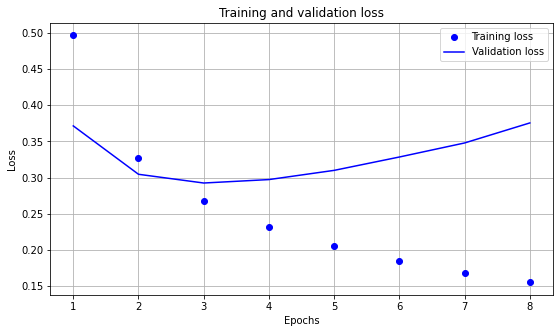

In [39]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

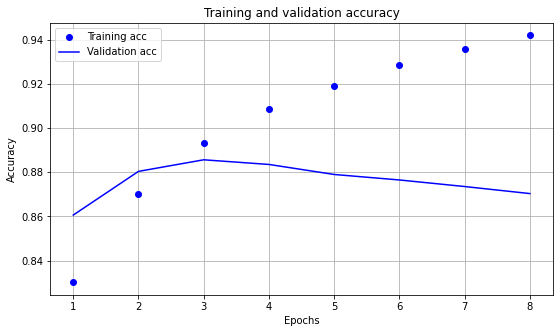

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [41]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [42]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Damn this is awesome for a simple trick taking game! Amazing design, very solid."
score: 1.000000
actual value:1

input:
"Amazing rondelle-type game"
score: 1.000000
actual value:1

input:
"gesleevt"
score: 1.000000
actual value:1

input:
"A1M1"
score: 1.000000
actual value:1

input:
"Played it 4 times and it is ok.  It was dull and extremely a lot of math involved and didn't feel immersive."
score: 0.000000
actual value:0

input:
"Disclaimer: played just 2P game.  Some really great things about this game, but it never had a feeling of progression.  The engine-building is quite fun.  I don't mind how wordy the cards are.  Lots of variability.  I wish there was a real timer mechanic.  Felt broken with 2 players."
score: 0.000000
actual value:0

input:
"After playing this a few times I think it’s safe to say it surpasses TM.  The technology track takes this game to the next level. Compared to the cult track it is infinitely more interesting and actually adds strategy to the game 

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [43]:
## APPLY MODEL ON NON-RATED COMMENTS

In [44]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

14/14 - 0s
input:
"Can play up to 4, but not much player interaction. Reviews compare to Sudoku."
score: 1.000000

input:
"ACCESSORIES: Top Shelf Gamer Upgrade Kit"
score: 1.000000

input:
"Not played  * Weight: Medium (2.82) * Player count: Community 3, 4 / Best 3 * Mechanisms: Area Majority-Influence / Dice Rolling / End Game Bonuses / Relative Movement / Rondel / Solo-Solitaire Game / Trading / Victory Points as a Resource / Worker Placement / Worker Placement with Dice Workers  SMALL"
score: 1.000000

input:
"Interesting new 4X-esque Civ-game with a weird theme. "
score: 0.000000

input:
"2020 - 4.62 - #146 Aesthetics - 8.5 Components - 8.5 Concept - 8.5 Mechanisms - 8.5 Combined Total - 34/40"
score: 1.000000

input:
"Would like, but not at scalpers prices"
score: 1.000000

input:
"2019 Christmas from Miller-Fridays"
score: 1.000000

input:
"deck building best at 3 western theme, good looking  but long"
score: 1.000000

input:
"Kickstarter, expected February 2021"
score: 1.000000


## REGRESSOR

In [45]:
def build_regressor():
    return build_model(hub_layer, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000022A9B4CBA60>,
             param_grid={})

In [46]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [47]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [48]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [49]:
epochs = range(1, len(mean_squared_error) + 1) 

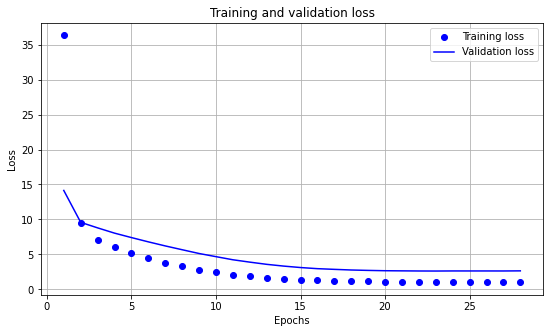

In [50]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

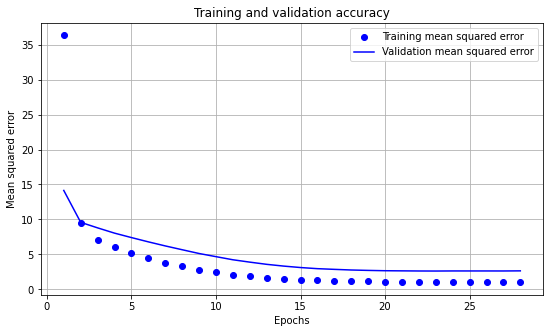

In [51]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [52]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Damn this is awesome for a simple trick taking game! Amazing design, very solid."
score: 8.64
actual: 8.50 

input: 
"Amazing rondelle-type game"
score: 9.12
actual: 9.00 

input: 
"gesleevt"
score: 8.84
actual: 9.00 

input: 
"A1M1"
score: 8.60
actual: 9.00 

input: 
"Played it 4 times and it is ok.  It was dull and extremely a lot of math involved and didn't feel immersive."
score: 5.02
actual: 6.00 

input: 
"Disclaimer: played just 2P game.  Some really great things about this game, but it never had a feeling of progression.  The engine-building is quite fun.  I don't mind how wordy the cards are.  Lots of variability.  I wish there was a real timer mechanic.  Felt broken with 2 players."
score: 6.88
actual: 6.00 

input: 
"After playing this a few times I think it’s safe to say it surpasses TM.  The technology track takes this game to the next level. Compared to the cult track it is infinitely more interesting and actually adds strategy to the game rather than just being 

## COMPARE CLASSIFIER VS REGRESSOR

In [53]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"The main and player boards are printed too dark for my tastes. You NEED good lighting."
    reg score: 7.57
    clf score: 1

"Action Point Allowance System Cooperative Play Deck / Pool Building Hand Management Role Playing Variable Player Powers"
    reg score: 7.92
    clf score: 1

"Mayday Standard Mayday Mini Euro"
    reg score: 7.24
    clf score: 1

"Sammelbestellung über SO (Thomas Krulich), August 2019 "
    reg score: 9.00
    clf score: 1

"sleeved before play. stickers not used. pads not used.  "
    reg score: 7.05
    clf score: 1

"with board extension, with metail coins-all, large action tokens"
    reg score: 6.72
    clf score: 0

"Heavy Board Games: -*Through the Ages -Blood Rage -Terraforming Mars -Cry Havoc -Twilight Struggle  -Great Western Trail -Mansions of Madness "
    reg score: 4.53
    clf score: 1

"I really dislike this for some reason..."
    reg score: 6.72
    clf score: 1

"Kickstarter Collectors Edition "
    reg score: 8.82
    clf score: 1

"With 

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [54]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.18 |           3845 |
| 128721 |          7.62 |            249 |
| 162886 |          8.35 |           3519 |
| 167355 |          8.42 |           1810 |
| 167791 |          8.21 |           8244 |


In [55]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [56]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.12 |            256 |
| 128721 |          8.32 |             50 |
| 162886 |          8.06 |            312 |
| 167355 |          8.20 |            214 |
| 167791 |          8.19 |            440 |


In [57]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [58]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/oaD1ZQ3...","<a href=""https://boardgamegeek.com/boardgame/2...",8.307619,7.835849,8.192222,1,2021
1,"<img src=""https://cf.geekdo-images.com/A7IOpPt...","<a href=""https://boardgamegeek.com/boardgame/2...",7.357140,7.989673,7.405875,2,2017
2,"<img src=""https://cf.geekdo-images.com/KTKXgGG...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,5.828681,7.914341,3,2021
3,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.857066,7.761272,7.848600,4,2020
4,"<img src=""https://cf.geekdo-images.com/Zdt8l4o...","<a href=""https://boardgamegeek.com/boardgame/2...",8.323567,8.235052,8.293045,5,2021


In [59]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [60]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Destinies,8.307619,7.835849,8.192222,1,2021
2,,Fantasy Realms,7.357140,7.989673,7.405875,2,2017
3,,The Goonies: Never Say Die,10.000000,5.828681,7.914341,3,2021
4,,Lost Ruins of Arnak,7.857066,7.761272,7.848600,4,2020
5,,Sleeping Gods,8.323567,8.235052,8.293045,5,2021


In [61]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,The Goonies: Never Say Die,10.000000,5.828681,7.914341,3,2021
2,,Chronicles of Drunagor: Age of Darkness,9.309524,8.366658,9.203285,34,2021
3,,Eclipse: Second Dawn for the Galaxy,8.742227,8.271768,8.668746,46,2020
4,,Brass: Birmingham,8.682599,8.128133,8.632273,24,2018
5,,Middara: Unintentional Malum – Act 1,8.612134,8.244618,8.523040,44,2019


In [62]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.309524,8.366658,9.203285,34,2021
2,,Lost Ruins of Arnak: The Search for Professor Kutil,8.500000,10.132860,9.044287,16,2021
3,,Eclipse: Second Dawn for the Galaxy,8.742227,8.271768,8.668746,46,2020
4,,Brass: Birmingham,8.682599,8.128133,8.632273,24,2018
5,,Gloomhaven: Jaws of the Lion,8.602076,8.055665,8.548364,23,2020


In [63]:
# model.save('saved_model\my_model')

In [64]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [65]:
# some examples on "long" comments vs short comments

In [66]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [67]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Interesting management game with factions having different abilities and specificities.  Too early to rate the game, though.  Date of comment: November 2016"
score: 5.39

"Like others, giving it a 10 when the game does not even exist yet is just hype. Objectively speaking the game is still not playable or unplayable. So 1 makes more sense to me. Peace!"
score: 5.49

"90–115 Min Playing Time Weight: 3.39 / 5   Area Majority / Influence Force Commitment Grid Movement Hexagon Grid King of the Hill   HEAVY STRATEGIC GAME 4 (5) players  AUS"
score: 5.67

"Absurdly high production value. Game is surprisingly streamlined for how much is going on. Has a run away leader problem. Game is very punishing to new players because of how efficiency oriented it is."
score: 5.86

"(05/11/2017) - Backed on Kickstarter!  (08/08/2018) - Campaign fulfillment complete!  (08/31/2020) - SOLD"
score: 6.00

"Sold. I played someone else's copy and decided that this was a very good game, but it probably wouldn't 